In [1]:
pip install holidays

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.2/378.2 kB 7.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 58.6 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 12.1 MB/s eta 0:00:00
  Created wheel for PyMeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=731999 sha256=bec9627477d0d6ea47ddcc77c84278db440b1d6b0f0e63d42bed17ab41525896
  Stored in directory: /home/ec2-user/.cache/pip/wheels/74/47/c4/678b0a3d5213e2f8500f3ea0f8dc3c81478e5b806c557dff58
Successfully built PyMeeus
Note: you may need to restart the kernel to use updated packages.


In [8]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm import tqdm

import holidays

from functools import partial
import scipy as sp

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import rankdata
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit, GroupKFold
from sklearn.metrics import mean_squared_error, roc_auc_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/Pog-Series/Rob-Sleep-Prediction/train.csv'
file_key_2 = 'Tabular-Playground-Series/Pog-Series/Rob-Sleep-Prediction/test.csv'
file_key_3 = 'Tabular-Playground-Series/Pog-Series/Rob-Sleep-Prediction/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
train['date'] = pd.to_datetime(train['date'])

test = pd.read_csv(file_content_stream_2)
test['date'] = pd.to_datetime(test['date'])

submission = pd.read_csv(file_content_stream_3)

# Feature Engineering

In [9]:
def get_holidays(df):
    years_list = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

    holiday_US = holidays.CountryHoliday('US', years = years_list)
    holiday_dict = holiday_US.copy()

    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    
#     return df
    return df.drop(columns = ['holiday_name'])


def feature_engineer(df):
    
    new_df = df.copy()
    new_df["month"] = df["date"].dt.month
    new_df["month_sin"] = np.sin(new_df['month'] * (2 * np.pi / 12))
#     new_df["month_cos"] = np.cos(new_df['month'] * (2 * np.pi / 12))
    
    new_df["day"] = df["date"].dt.day
    new_df["day_sin"] = np.sin(new_df['day'] * (2 * np.pi / 12))
#     new_df["day_cos"] = np.cos(new_df['day'] * (2 * np.pi / 12))
    
    new_df["day_of_week"] = df["date"].dt.dayofweek
#     new_df["day_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x <= 3 else(1 if x == 4 else (2 if x == 5 else (3))))
    
    new_df["day_of_year"] = df["date"].dt.dayofyear
    new_df["year"] = df["date"].dt.year
    
    return new_df

train = feature_engineer(train)
test = feature_engineer(test)

train = get_holidays(train)
test = get_holidays(test)

train.loc[((train['date'] >= '2017-09-27') & (train['date'] <= '2018-06-12')), 'sleep_hours'] = train.loc[((train['date'] >= '2017-09-27') & (train['date'] <= '2018-06-12')), 'sleep_hours'] / 1.94 

X = train.drop(columns = ['date', 'sleep_hours', 'year'], axis = 1)
Y = train['sleep_hours']

test = test.drop(columns = ['date', 'sleep_hours', 'year'], axis = 1)

train = train[train['date'] > '2015-07-20'].reset_index(drop = True)

# Visualization

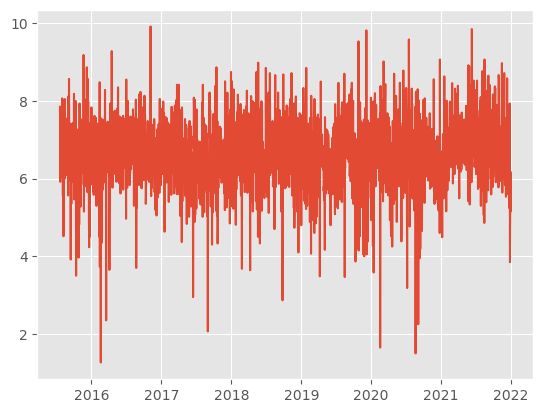

In [10]:
plt.plot('date', 'sleep_hours', data = train);

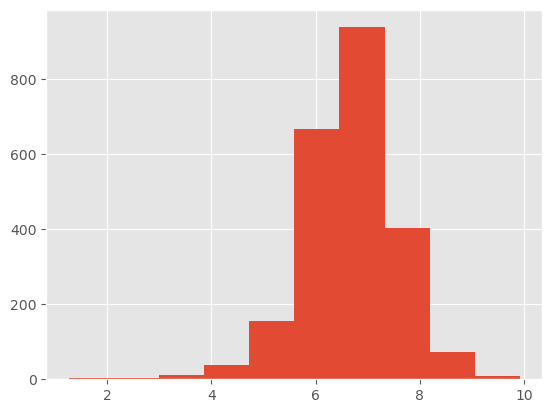

In [18]:
plt.hist('sleep_hours', data = train);

In [13]:
train[train['sleep_hours'] > 8].head(20)

,date,sleep_hours,month,month_sin,day,day_sin,day_of_week,day_of_year,year,is_holiday
9,2015-08-01,8.066667,8,-8.660254e-01,1,5.000000e-01,5,213,2015,0
22,2015-08-14,8.050000,8,-8.660254e-01,14,8.660254e-01,4,226,2015,0
41,2015-09-02,8.116667,9,-1.000000e+00,2,8.660254e-01,2,245,2015,0
45,2015-09-06,8.566667,9,-1.000000e+00,6,1.224647e-16,6,249,2015,0
71,2015-10-02,8.183333,10,-8.660254e-01,2,8.660254e-01,4,275,2015,0
121,2015-11-21,9.183333,11,-5.000000e-01,21,-1.000000e+00,5,325,2015,0
125,2015-11-25,8.050000,11,-5.000000e-01,25,5.000000e-01,2,329,2015,0
138,2015-12-08,8.866667,12,-2.449294e-16,8,-8.660254e-01,1,342,2015,0
143,2015-12-13,8.566667,12,-2.449294e-16,13,5.000000e-01,6,347,2015,0
205,2016-02-13,8.483333,2,8.660254e-01,13,5.000000e-01,5,44,2016,0


In [16]:
train[train['sleep_hours'] < 4]

,date,sleep_hours,month,month_sin,day,day_sin,day_of_week,day_of_year,year,is_holiday
54,2015-09-15,3.916667,9,-1.000000e+00,15,1.000000e+00,1,258,2015,0
82,2015-10-13,3.500000,10,-8.660254e-01,13,5.000000e-01,1,286,2015,0
95,2015-10-26,3.966667,10,-8.660254e-01,26,8.660254e-01,0,299,2015,0
206,2016-02-14,3.733333,2,8.660254e-01,14,8.660254e-01,6,45,2016,0
211,2016-02-19,1.266667,2,8.660254e-01,19,-5.000000e-01,4,50,2016,0
236,2016-03-18,2.350000,3,1.000000e+00,18,3.673940e-16,4,78,2016,0
253,2016-04-04,3.650000,4,8.660254e-01,4,8.660254e-01,0,95,2016,0
392,2016-08-22,3.700000,8,-8.660254e-01,22,-8.660254e-01,0,235,2016,0
678,2017-06-15,2.950000,6,1.224647e-16,15,1.000000e+00,3,166,2017,0
755,2017-08-31,2.066667,8,-8.660254e-01,31,-5.000000e-01,3,243,2017,0


In [19]:
train[train['is_holiday'] == 1]

,date,sleep_hours,month,month_sin,day,day_sin,day_of_week,day_of_year,year,is_holiday
46,2015-09-07,6.900000,9,-1.000000e+00,7,-5.000000e-01,0,250,2015,1
81,2015-10-12,6.116667,10,-8.660254e-01,12,-2.449294e-16,0,285,2015,1
111,2015-11-11,6.950000,11,-5.000000e-01,11,-5.000000e-01,2,315,2015,1
126,2015-11-26,6.666667,11,-5.000000e-01,26,8.660254e-01,3,330,2015,1
155,2015-12-25,7.333333,12,-2.449294e-16,25,5.000000e-01,4,359,2015,1
...,...,...,...,...,...,...,...,...,...,...
2254,2021-11-11,7.233333,11,-5.000000e-01,11,-5.000000e-01,3,315,2021,1
2267,2021-11-25,7.241667,11,-5.000000e-01,25,5.000000e-01,3,329,2021,1
2296,2021-12-24,5.233333,12,-2.449294e-16,24,-4.898587e-16,4,358,2021,1
2297,2021-12-25,7.933333,12,-2.449294e-16,25,5.000000e-01,5,359,2021,1


<AxesSubplot: >

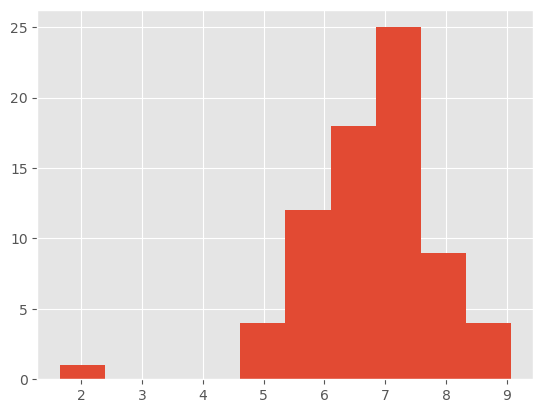

In [21]:
train[train['is_holiday'] == 1]['sleep_hours'].hist()

In [24]:
train[(train['is_holiday'] == 1) & (train['sleep_hours'] < 4)]

,date,sleep_hours,month,month_sin,day,day_sin,day_of_week,day_of_year,year,is_holiday
1635,2020-02-17,1.65,2,0.866025,17,0.5,0,48,2020,1
